# ETL: Heurist database -> Pandas dataframe

## 1. Set up the environment

### Dependencies

In addition to `jupyterlab` and the `heurist` package, pip install the following:
- `ipywidgets` for seeing the progress bar in the notebook
- `seaborn` for visualising the data analysis

In [ ]:
!pip install ipywidgets seaborn

For this data analysis example, I want to use DuckDB's nightly build to take advantage of a new date function.

In [ ]:
 !pip install --upgrade duckdb --pre --upgrade

### Credentials

Either get your authentication credentials from a `.env` file or directly type them into the cell.

**Do not** directly type in your credentials if you're sharing the notebook with anyone / saving it somewhere public.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv() 

HEURIST_DATABASE = os.getenv("DB_NAME")
HEURIST_LOGIN = os.getenv("DB_LOGIN")
HEURIST_PASSWORD = os.getenv("DB_PASSWORD")

## 2. Set up the Python objects

### DuckDB connection

Create a DuckDB database connection. In this case, we'll create an in-memory connection that will disappear after this notebook is closed.

If you want to save the created DuckDB database, enter a file path in the `connect()` method, i.e. `duckdb.connect("heurist.db")`

In [2]:
import duckdb

conn = duckdb.connect()

## 3. Run the ETL workflow

Using the Heurist login credentials, which you saved to constants, and the DuckDB connection, run the ETL workflow within the context of an active connection to the API.

By default, without specifying anything, the ETL function collects records from your "My record types" group in Heurist.

If you want to collect records from additional groups, i.e. "Place, features," use the `record_group_names` parameter, as shown below:

```python
extract_transform_load(
    client = client,
    duckdb_connection = conn,
    record_group_names = ("My record types", "Place, features")
)
```

Based on the type of analysis you want to do, adjust the record groups targeted for extraction.

In [3]:
from heurist.api.connection import HeuristAPIConnection
from heurist.workflows import extract_transform_load

with HeuristAPIConnection(
    db = HEURIST_DATABASE,
    login = HEURIST_LOGIN,
    password = HEURIST_PASSWORD
) as client:
    extract_transform_load(
        client = client,
        duckdb_connection = conn,
    )

Get Records ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━ 14/15 0:00:14

### Look at the results

Use DuckDB's `"show tables;"` SQL query to review the tables the ETL workflow created.

In [4]:
conn.sql("show tables")

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ Digitization  │
│ DocumentTable │
│ Footnote      │
│ Genre         │
│ Images        │
│ Part          │
│ PhysDesc      │
│ Repository    │
│ Scripta       │
│ Stemma        │
│ Story         │
│ Storyverse    │
│ TextTable     │
│ Witness       │
│ dty           │
│ rst           │
│ rtg           │
│ rty           │
│ trm           │
├───────────────┤
│    19 rows    │
└───────────────┘

Use DuckDB's `.df()` method to convert a table (technically a "relation" in SQL jargon) into a Pandas dataframe.

In [5]:
wit_df = conn.table("Witness").df()
wit_df

,H-ID,type_id,is_manifestation_of H-ID,observed_on_pages H-ID,last_observed_in_doc H-ID,is_unobserved,is_unobserved TRM-ID,claim_freetext,used_to_follow_fragment H-ID,used_to_follow_witness H-ID,...,number_of_hands,scribe_note,place_of_creation H-ID,place_of_creation_source,described_by_source H-ID,described_at_URL,reference_notes,review_status,review_status TRM-ID,review_note
0,48794,105,48791.0,[48795],NaN,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[],[https://etheses.bham.ac.uk/id/eprint/5748/1/T...,None,Open,9698,None
1,47500,105,47473.0,[47501],47498.0,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://www.handschriftencensus.de/9746],None,Action required,9697,Check.
2,47897,105,47896.0,[47898],NaN,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://www.kb.nl/ontdekken-bewonderen/topstu...,None,Action required,9697,Check.
3,47756,105,47755.0,[47757],NaN,No,9483,<NA>,<NA>,<NA>,...,1.0,None,[],<NA>,[47483],[https://opac.kbr.be/Library/search.aspx?SC=KB...,None,Action required,9697,Check.
4,47978,105,47977.0,[47979],NaN,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://digitalcollections.universiteitleiden...,None,Action required,9697,Check.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,48051,105,48049.0,[48052],NaN,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://www.arlima.net/eh/huon_de_bordeaux/nl...,None,Action required,9697,Kienhorst zegt in BNM?
171,47458,105,47293.0,[47459],47457.0,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[],[https://www.handschriftencensus.de/18870],None,Action required,9697,Ref.
172,47454,105,47293.0,[47455],47453.0,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[],[],None,Action required,9697,Ref.
173,47433,105,46322.0,[47434],47432.0,No,9483,<NA>,<NA>,<NA>,...,NaN,None,[],<NA>,[],[],None,Action required,9697,"Check, ref."


## 4. Data analysis

#### Problem

My database's Witness records have a `date_of_creation`.

The dates are often fuzzy, which the `heurist` ETL workflow parsed as [structured](https://duckdb.org/docs/stable/sql/data_types/struct.html) data types.

#### Question

How precise are my Witness records' dates?

In [ ]:
# Calculate the number of seconds in a year
60 * 60 * 24 * 365

In [6]:
sql = """
SELECT
    epoch(w.date_of_creation.estMaxDate - w.date_of_creation.estMinDate) / 31536000 as wit_precision_in_years,
    date_part('year', list_aggregate([w.date_of_creation.estMinDate, w.date_of_creation.estMaxDate], 'avg')) as wit_median_year,
    date_part('decade', list_aggregate([w.date_of_creation.estMinDate, w.date_of_creation.estMaxDate], 'avg')) as wit_decade,
    date_part('year', list_aggregate([t.date_of_creation.estMinDate, t.date_of_creation.estMaxDate], 'avg')) as text_median_year,
    date_part('decade', list_aggregate([t.date_of_creation.estMinDate, t.date_of_creation.estMaxDate], 'avg')) as text_decade,
    wit_decade - text_decade estimated_decades_since_text,
    g.preferred_name as genre
FROM Witness w
LEFT JOIN TextTable t
    ON w."is_manifestation_of H-ID" = t."H-ID"
LEFT JOIN Genre g
    ON t."specific_genre H-ID" = g."H-ID"
WHERE t.language_COLUMN like 'dum%'
"""
conn.sql(sql).df()

,wit_precision_in_years,wit_median_year,wit_decade,text_median_year,text_decade,estimated_decades_since_text,genre
0,220.139726,1400,140,1259,125,15,Other
1,25.013699,1323,132,1280,128,4,Arthurroman
2,30.016438,1406,140,1315,131,9,Other
3,20.010959,1325,132,1225,122,10,Arthurroman
4,45.024658,1313,131,1275,127,4,Other
...,...,...,...,...,...,...,...
164,400.263014,1300,130,1325,132,-2,Other
165,20.008219,1300,130,1205,120,10,None
166,220.139726,1400,140,1270,127,13,None
167,220.139726,1400,140,1270,127,13,None


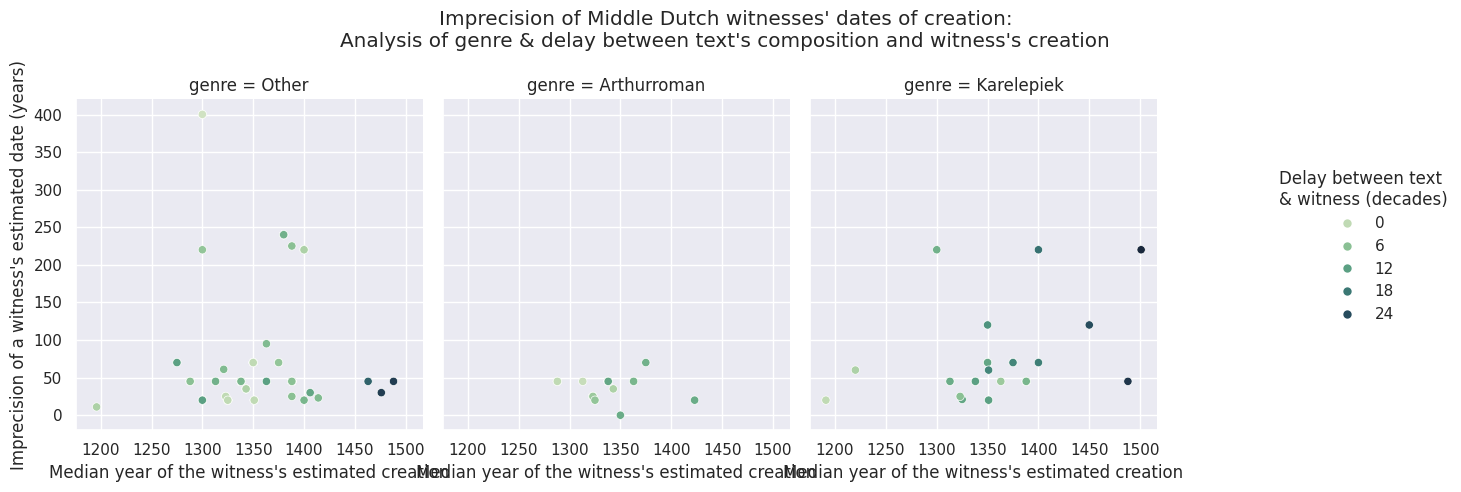

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relation and convert it to a pandas dataframe 
df = conn.sql(sql).df()

cmap = sns.cubehelix_palette(rot=-.5, as_cmap=True)
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Create a scatter plot to view each witness's date distribution and precision
graph = sns.relplot(
    data=df,
    x="wit_median_year",
    y="wit_precision_in_years",
    hue="estimated_decades_since_text",
    col="genre",
    palette=cmap,
    height=5,
    aspect=0.8,
)

# Set labels
graph.tick_params(axis="x", labelbottom=True)
graph.set_ylabels("Imprecision of a witness's estimated date (years)")
graph.set_xlabels("Median year of the witness's estimated creation")
graph._legend.set_title("Delay between text\n& witness (decades)")

graph.fig.suptitle("""Imprecision of Middle Dutch witnesses' dates of creation:
Analysis of genre & delay between text's composition and witness's creation""")

graph.tight_layout()